In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.pde import DirichletBVP2D, NoCondition2D
from neurodiffeq.pde import solve2D_system, ExampleGenerator2D, Monitor2D
%matplotlib notebook

In [2]:
class BCOnU:
    """for u(x, y), impose u(x, -1) = u(x, 1) = 0; dudx(0, y) = dudy(L, y) = 0"""
    
    @staticmethod
    def _nn_output_2input(net, xs, ys):
        xys = torch.cat((xs, ys), 1)
        return net(xys)
    
    def __init__(self, x_min, x_max, y_min, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        
    def enforce(self, net, x, y):
        uxy = self._nn_output_2input(net, x, y)

        x_ones = torch.ones_like(x, requires_grad=True)
        y_ones = torch.ones_like(y, requires_grad=True)
        x_ones_min = self.x_min * x_ones
        x_ones_max = self.x_max * x_ones
        uxminy = self._nn_output_2input(net, x_ones_min, y)
        uxmaxy = self._nn_output_2input(net, x_ones_max, y)

        x_tilde = (x - self.x_min) / (self.x_max - self.x_min)
        y_tilde = (y - self.y_min) / (self.y_max - self.y_min)

        return y_tilde*(1-y_tilde) * (
            uxy - x_tilde * (self.x_max - self.x_min) * diff(uxminy, x_ones_min) \
            + 0.5 * x_tilde ** 2 * (self.x_max - self.x_min) * (
                diff(uxminy, x_ones_min) - diff(uxmaxy, x_ones_max)
            )
        )

class BCOnP:
    """for p(x, y), impose p(0, y) = p_max; p(L, y) = p_min"""
    
    @staticmethod
    def _nn_output_2input(net, xs, ys):
        xys = torch.cat((xs, ys), 1)
        return net(xys)
    
    def __init__(self, x_min, x_max, p_x_min, p_x_max):
        self.x_min = x_min
        self.x_max = x_max
        self.p_x_min = p_x_min
        self.p_x_max = p_x_max
        
    def enforce(self, net, x, y):
        uxy = self._nn_output_2input(net, x, y)
        x_tilde = (x - self.x_min) / (self.x_max - self.x_min)

        return (1-x_tilde)*self.p_x_min + x_tilde*self.p_x_max \
            + x_tilde*(1-x_tilde)*uxy

<IPython.core.display.Javascript object>


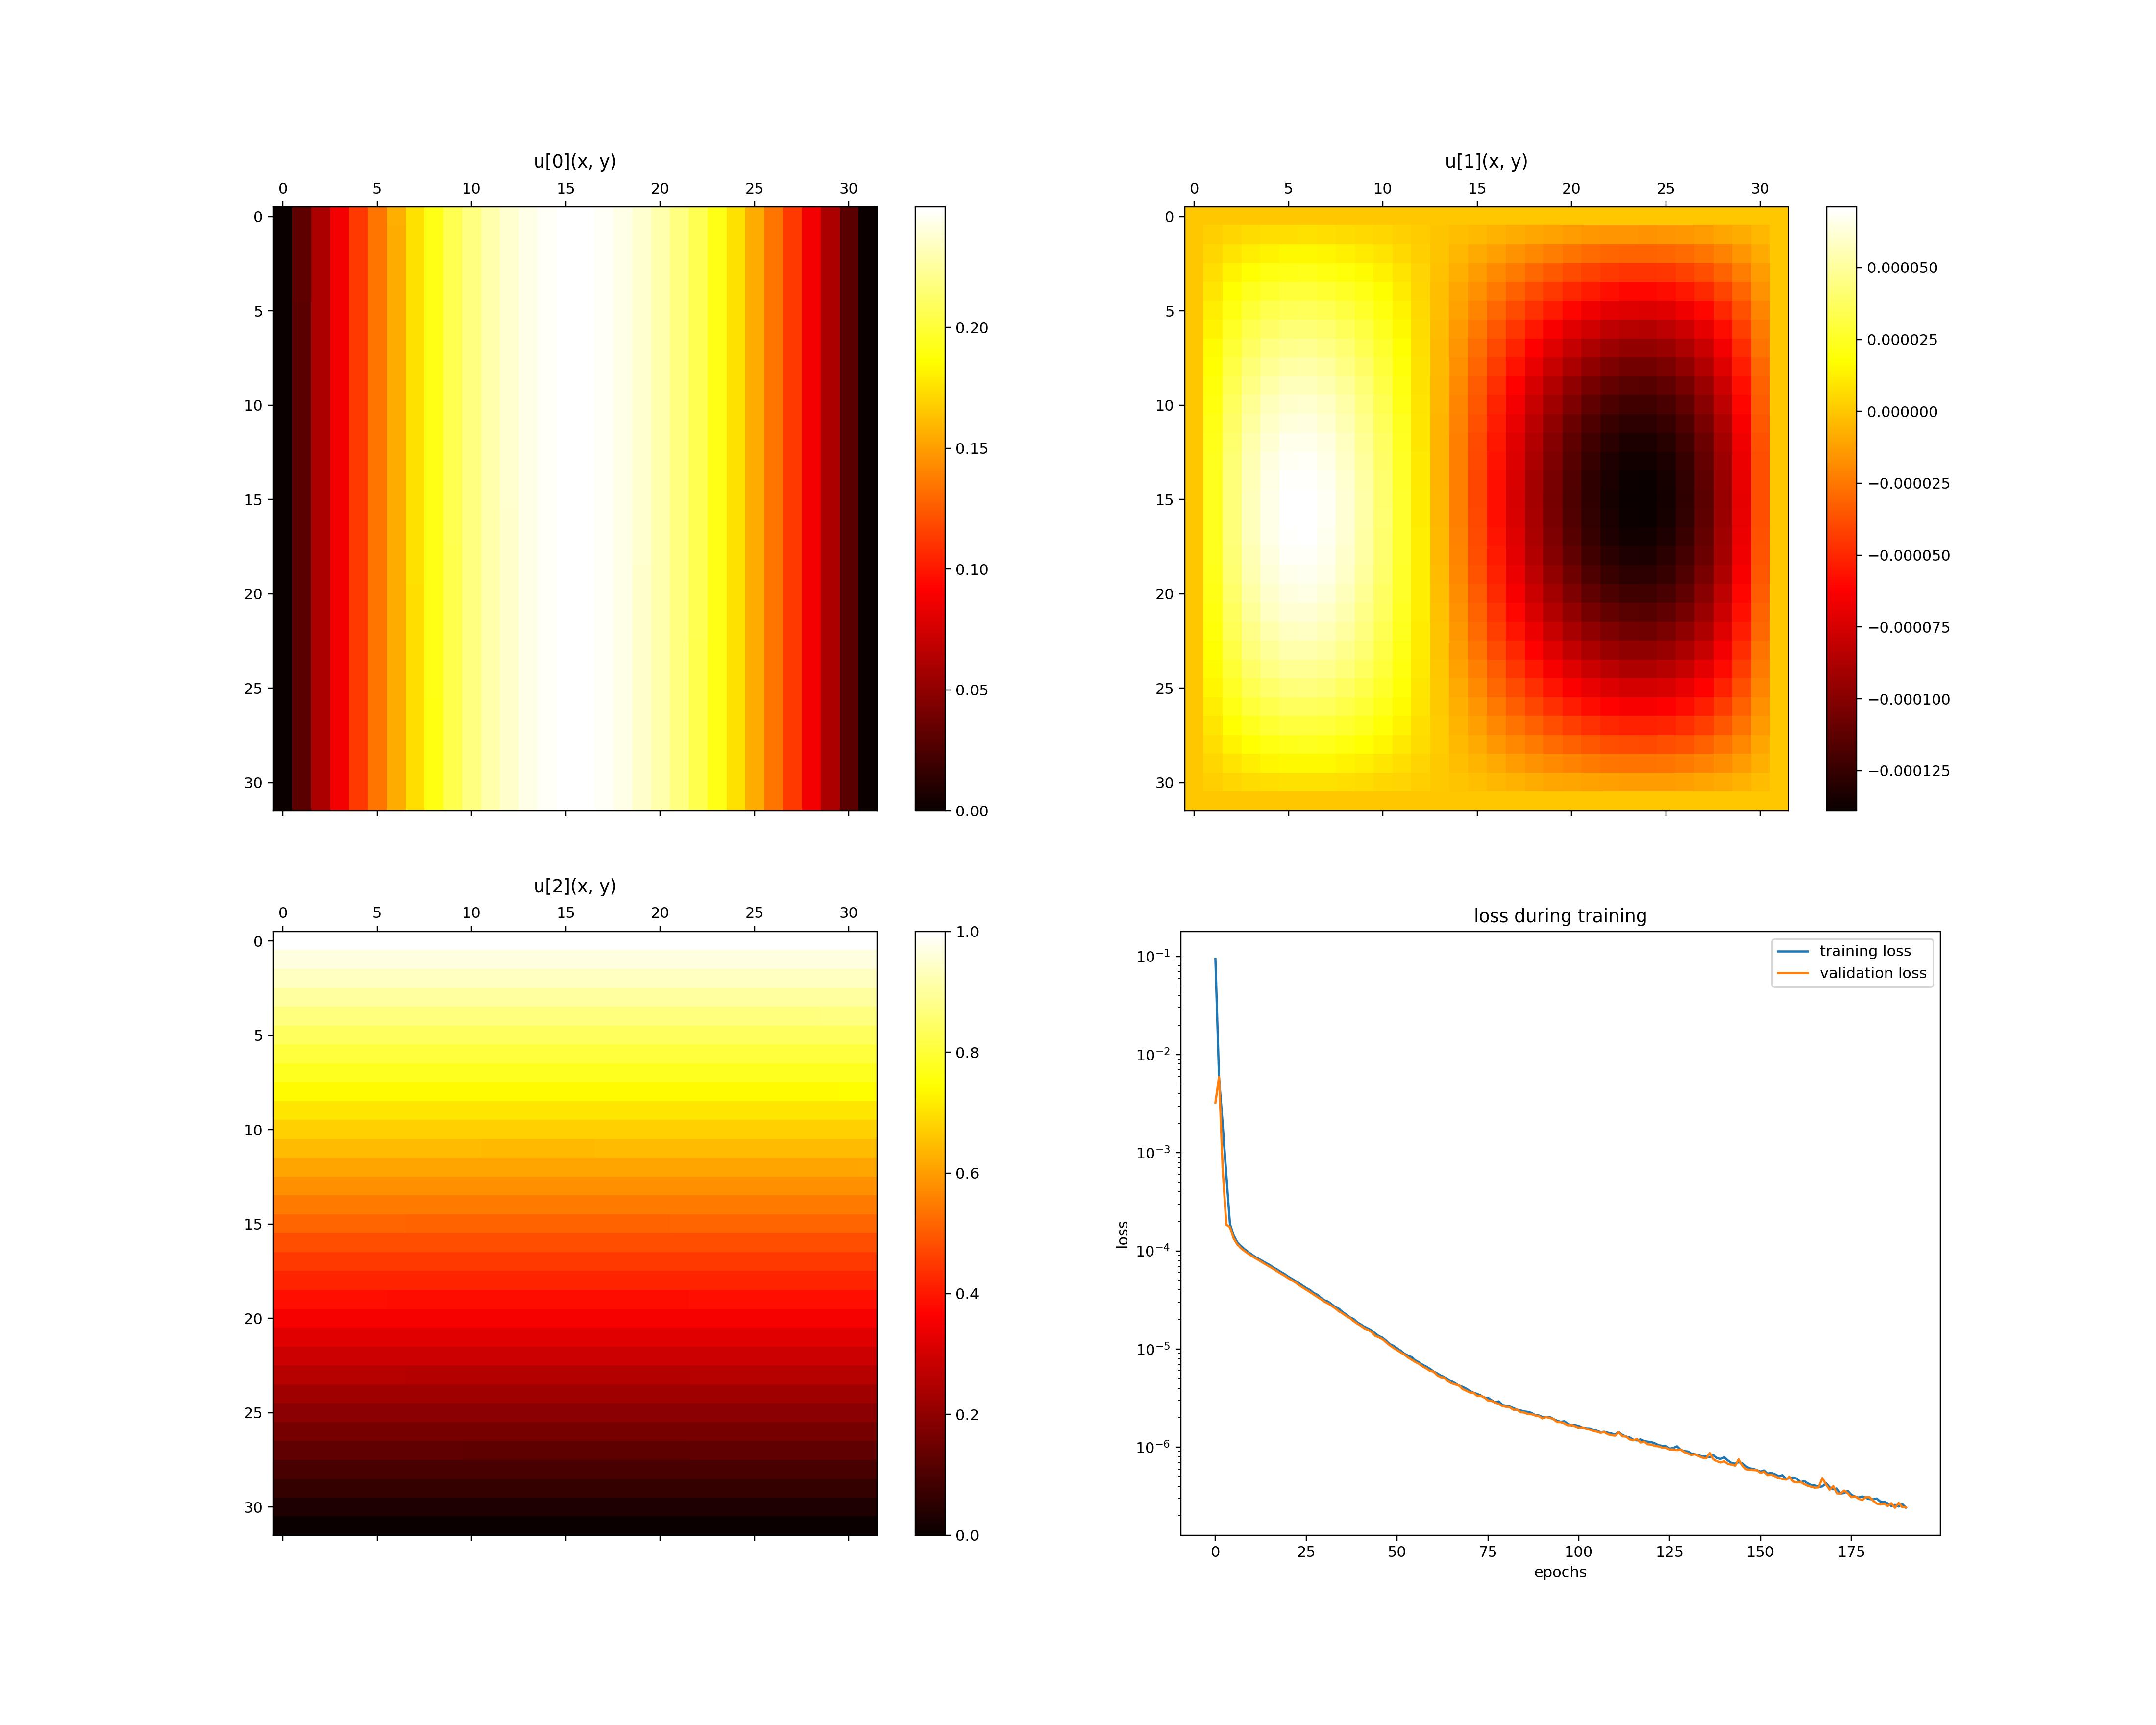

In [3]:
%matplotlib notebook
L = 2.0
mu = 1.0
P1, P2 = 1.0 ,0.0
poiseuille = lambda u, v, p, x, y: [
    mu * (diff(u, x, order=2) + diff(u, y, order=2)) - diff(p, x),
    mu * (diff(v, x, order=2) + diff(v, y, order=2)) - diff(p, y),
    diff(u, x) + diff(v, y)
]

bc_on_u = BCOnU(
    x_min=0,
    x_max=L,
    y_min=-1,
    y_max=1, 
)
bc_on_v = DirichletBVP2D(
    x_min=0,  x_min_val=lambda y: 0,
    x_max=L,  x_max_val=lambda y: 0,
    y_min=-1, y_min_val=lambda x: 0,
    y_max=1,  y_max_val=lambda x: 0
)
bc_on_p = BCOnP(
    x_min=0,
    x_max=L,
    p_x_min=P1,
    p_x_max=P2,  
)
conditions = [bc_on_u, bc_on_v, bc_on_p]

nets = [
    FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1, actv=nn.Softplus)
    for _ in range(3)
]
all_parameters = []
for net in nets: all_parameters += list(net.parameters())
adam = optim.Adam(all_parameters, lr=0.001)

solution_neural_net_poiseuille, _ = solve2D_system(
    pde_system=poiseuille, conditions=conditions, xy_min=(0, -1), xy_max=(L, 1),
    train_generator=ExampleGenerator2D((32, 32), (0, -1), (L, 1), method='equally-spaced-noisy'),
    max_epochs=200, batch_size=64, nets=nets, optimizer=adam,
    monitor=Monitor2D(check_every=10, xy_min=(0, -1), xy_max=(L, 1))
)

In [4]:
def solution_analytical_poiseuille(xs, ys):
    us = (P1-P2)/(L*2*mu) * (1-ys**2)
    vs = np.zeros_like(xs)
    ps = P1 + (P2-P1) * xs/L
    return [us, vs, ps]

<IPython.core.display.Javascript object>


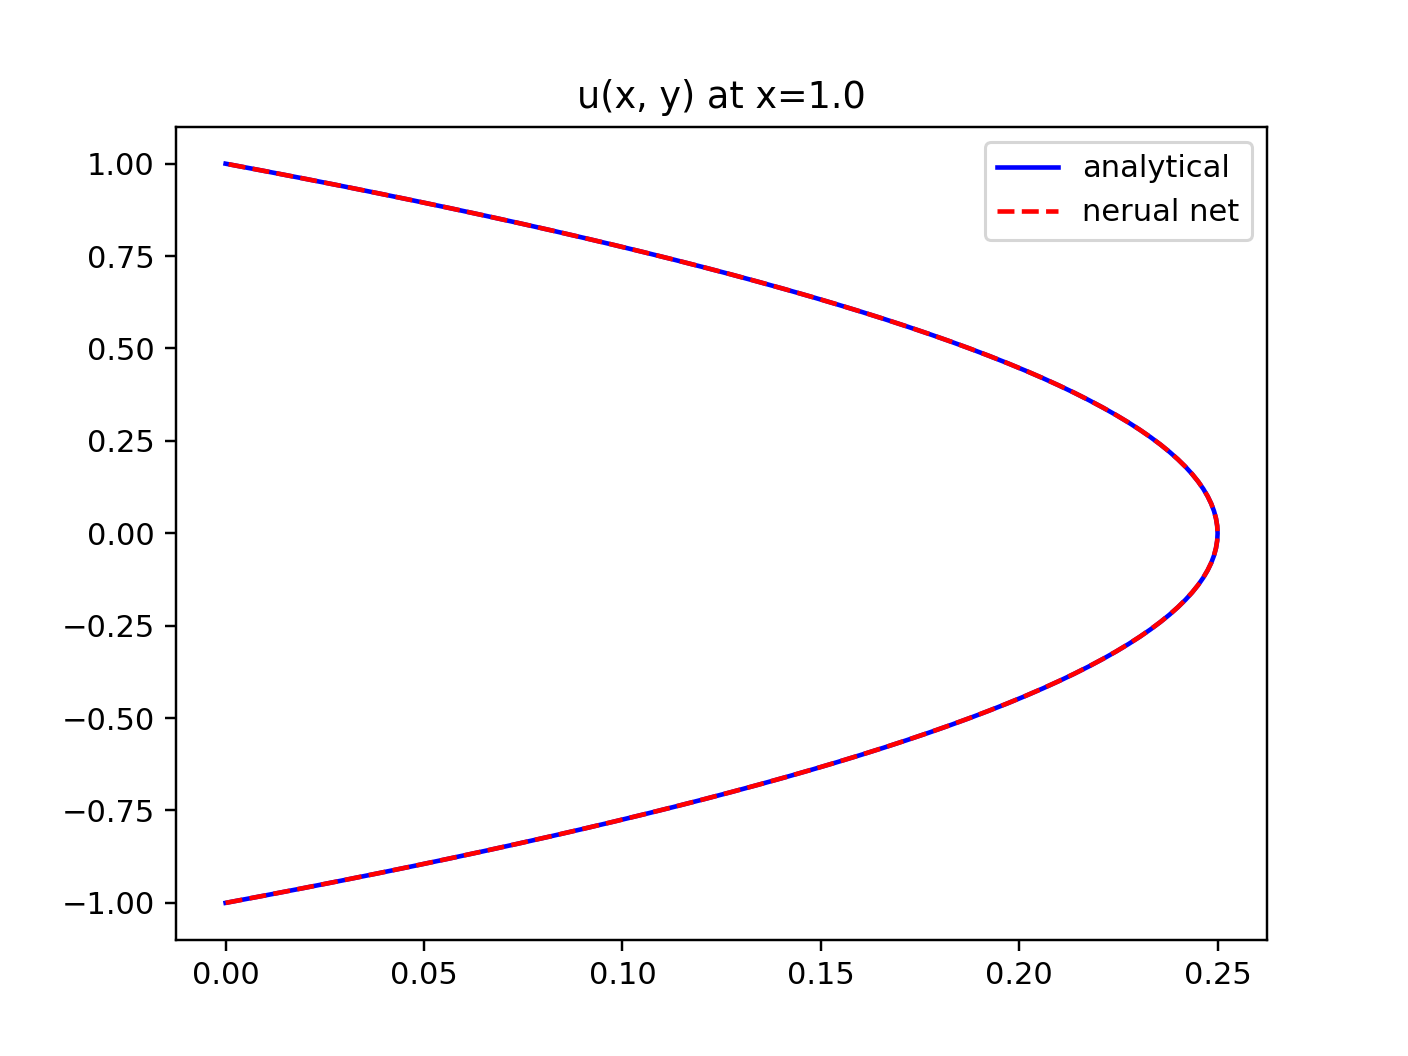

In [5]:
xs, ys = L/2 * np.ones(101), np.linspace(-1, 1, 101)
us_ana, _, _ = solution_analytical_poiseuille(xs, ys)
us_net, _, _ = solution_neural_net_poiseuille(xs, ys, as_type='np')
plt.plot(us_ana, ys, 'b-', label='analytical')
plt.plot(us_net, ys, 'r--',label='nerual net')
plt.title(f'u(x, y) at x={L/2}')
plt.legend()

In [6]:
xs, ys = np.linspace(0, L, 101), np.linspace(-1, 1, 101)
xx, yy = np.meshgrid(xs, ys)
u_ana, v_ana, p_ana = solution_analytical_poiseuille(xx, yy)
u_net, v_net, p_net = solution_neural_net_poiseuille(xx, yy, as_type='np')

In [7]:
def compare_contour(sol_ana, sol_net):
    fig = plt.figure(figsize=(18, 4))

    ax1 = fig.add_subplot(131)
    cs1 = ax1.contourf(xx, yy, sol_net, cmap='coolwarm')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_title('ANN-based solution')
    cbar1 = fig.colorbar(cs1, format='%.0e', ax=ax1)

    ax2 = fig.add_subplot(132)
    cs2 = ax2.contourf(xx, yy, sol_ana, cmap='coolwarm')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_aspect('equal', adjustable='box')
    ax2.set_title('analytical solution')
    cbar2 = fig.colorbar(cs2, format='%.0e', ax=ax2)

    ax3 = fig.add_subplot(133)
    cs3 = ax3.contourf(xx, yy, sol_net-sol_ana, cmap='coolwarm')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_aspect('equal', adjustable='box')
    ax3.set_title('residual of ANN-based solution')
    cbar3 = fig.colorbar(cs3, format='%.0e', ax=ax3)

<IPython.core.display.Javascript object>


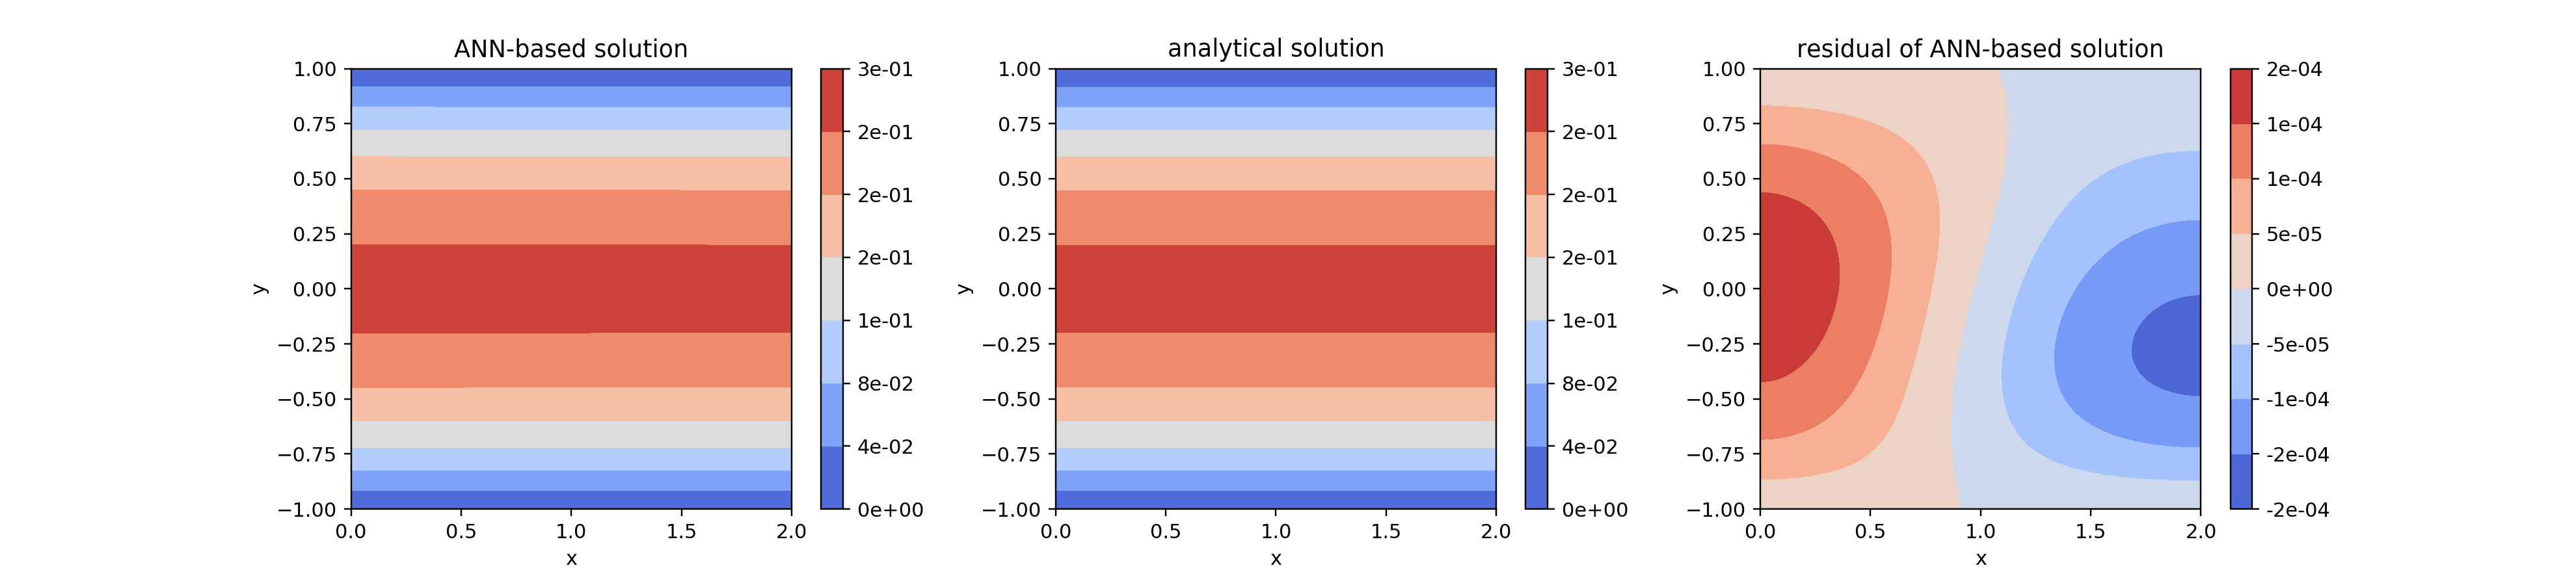

In [8]:
compare_contour(u_ana, u_net)

<IPython.core.display.Javascript object>


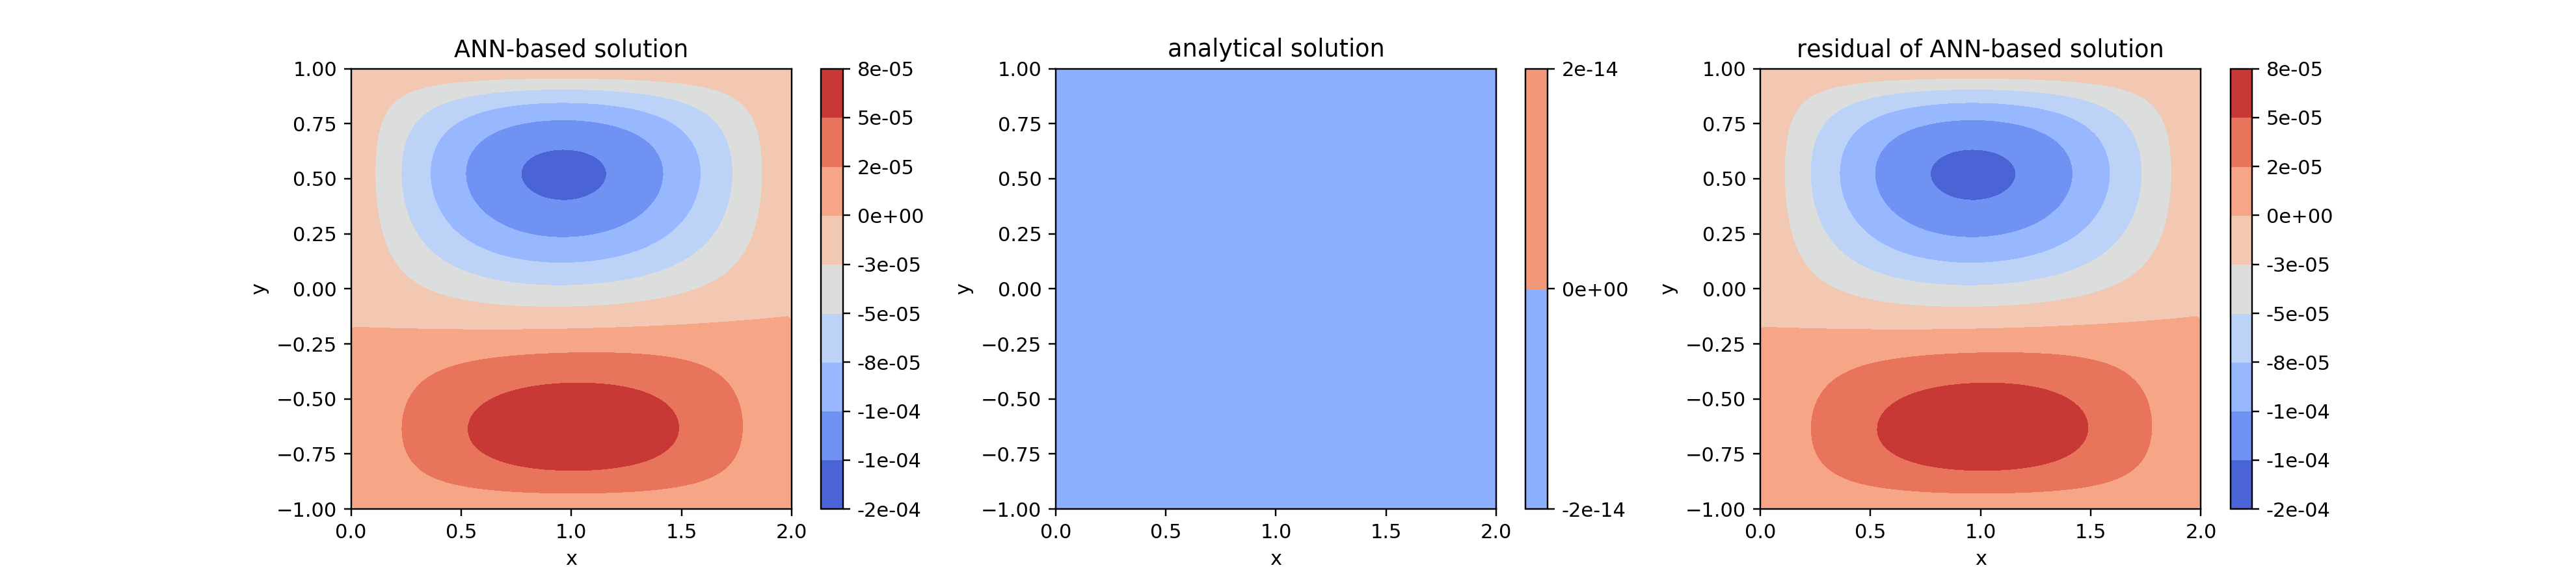

In [9]:
compare_contour(v_ana, v_net)

<IPython.core.display.Javascript object>


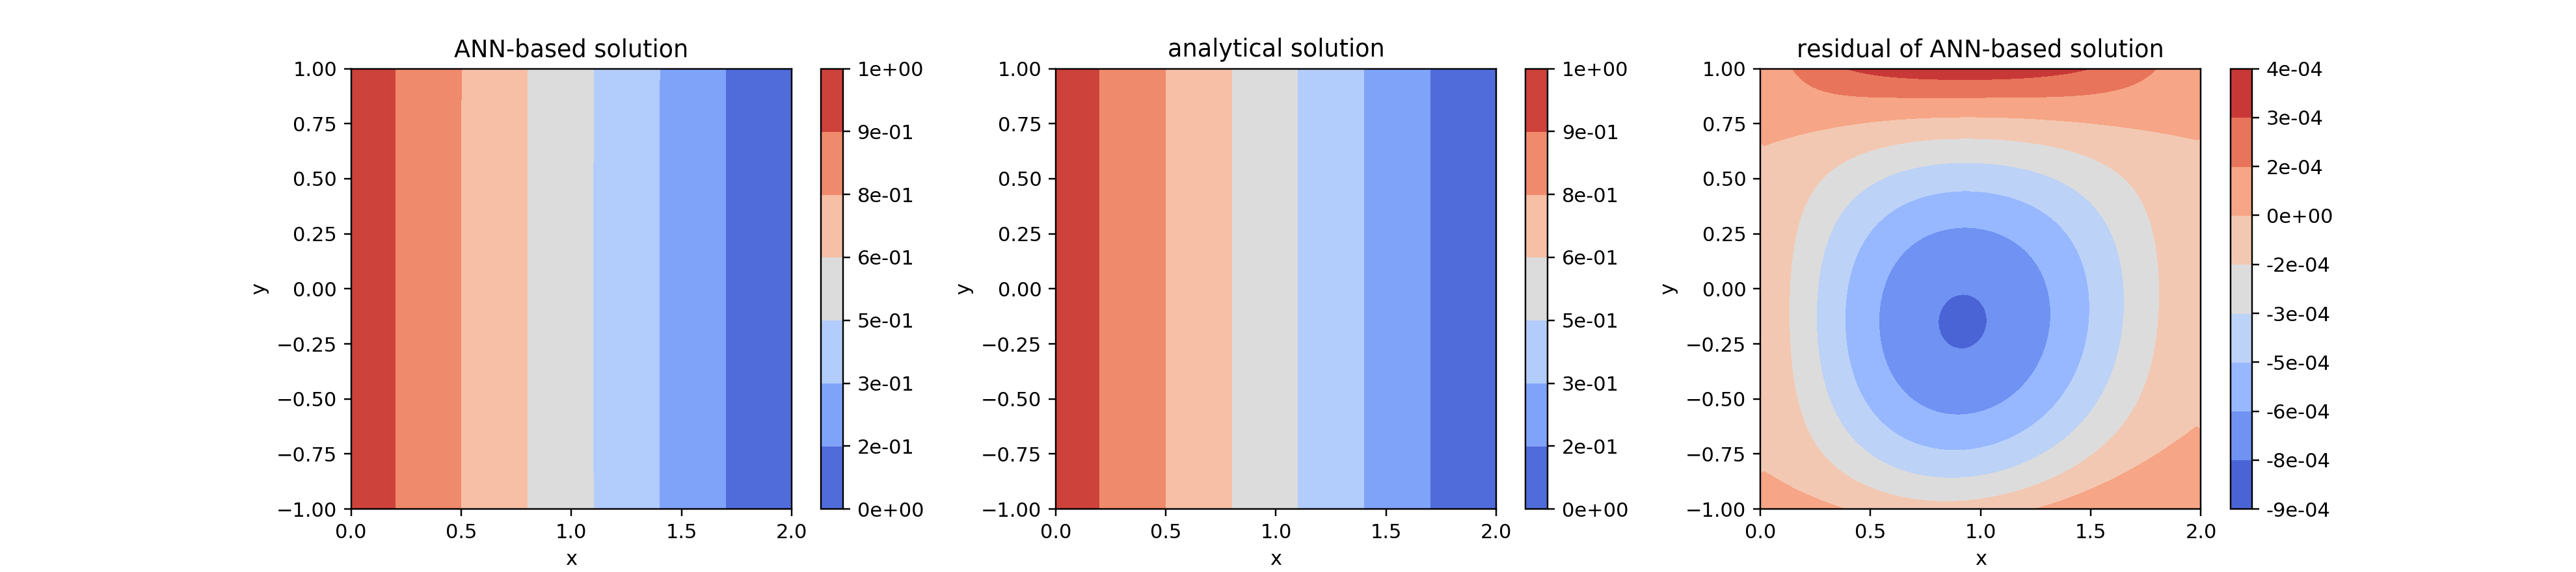

In [10]:
compare_contour(p_ana, p_net)